### Imports

In [1]:
import pandas as pd
import statsmodels as sm
import os
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use("../assets/plot_styles.mplstyle")

import numpy as np
from sklearn.preprocessing import RobustScaler
import arrow
import sys
from collections import Counter
sys.path.append('../library')
import ast

from tqdm import tqdm
import itertools

from midStats import *
from core import *
from plotting import *

colorPalette = loadPalette()


Bad key scatter.alpha in file ../assets/plot_styles.mplstyle, line 48 ('scatter.alpha: .5')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


### Overall Script Flow
- We're going to look at the composition of weekly top tens as a function of time

### Load Data

In [2]:
tmdbDf = pd.read_csv(os.path.join('../data/', 'tmdbDetails.csv'))
tmdbDf.drop_duplicates(inplace=True, keep='last')

bomDf = pd.read_csv(os.path.join('../data/', 'allBoxOffice.csv'))
bomDf.drop_duplicates(subset=['imdbId','dayNumber'], inplace=True, keep = 'last')
bomDf.dropna(subset=['date'], inplace=True)

/var/folders/zz/znvh8gg96055nsx1ptsrmmvc0000gn/T/ipykernel_64199/1070615201.py:1: DtypeWarning: Columns (1,24,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdbDf = pd.read_csv(os.path.join('../data/', 'tmdbDetails.csv'))


### Global Vars

In [3]:
plotWidth = 600
plotHeight = 600
saveImagePath = '../assets/savedImages/whatHappenedToTheComedy'

if not os.path.exists(saveImagePath):
    os.makedirs(saveImagePath)

### Get ranks of every week since earliest timestamp

In [24]:
bomDf['dateTs'] = pd.to_datetime(bomDf['date'])
bomDf['dateAr'] = bomDf['date'].apply(lambda x: arrow.get(x))

earliestDate = arrow.get(bomDf['dateTs'].min())
latestDate = arrow.now()

earliestDateDOW = earliestDate.format('dddd')
latestDateDOW = latestDate.format('dddd')

In [25]:
earliestValidDateStr = earliestDate.format('YYYY-MM-DDTHH:mm:ss')
earliestValidDateMd  = pd.to_datetime(earliestValidDateStr, utc=True)
latestValidDateStr   = latestDate.format('YYYY-MM-DDTHH:mm:ss')
latestValidDateMd    = pd.to_datetime(latestValidDateStr, utc=True)

In [26]:
bomDf = bomDf[bomDf['dateTs'] >= earliestValidDateMd]
bomDf = bomDf[bomDf['dateTs'] <= latestValidDateMd]

In [27]:
weeks = createSlidingWindows(l = list(arrow.Arrow.range('day', earliestValidDate, latestValidDate)), windowSize=7, overlap=0)
weeks = {i:{'dates':set(w)} for i,w in enumerate(weeks)}

In [28]:
bomDict = bomDf.to_dict('records') # Don't want to use modin or pandas for this

In [66]:
def makeYearWeek(dateTs):
    date = arrow.get(dateTs)
    year, week, _ = date.isocalendar()
    month = date.month

    return year, week, month

yearWeek = bomDf['dateTs'].apply(lambda x: makeYearWeek(x))

grouper = ['year', 'month']

bomDf[['year','week', 'month']] = yearWeek.to_list()

In [68]:
genreDict = tmdbDf.set_index('imdb_id')['genres'].to_dict()
bomDf['genres'] = bomDf['imdbId'].map(genreDict)

In [69]:
def getRankings(group):
    returnCols = ['rank','imdbId','genres']

    groupOut = group[returnCols].drop_duplicates(subset = ['rank','imdbId'], keep='last')

    return groupOut

g = bomDf.groupby(grouper).apply(lambda group: getRankings(group))
g.reset_index(drop=False, inplace=True)


/var/folders/zz/znvh8gg96055nsx1ptsrmmvc0000gn/T/ipykernel_64199/3033879109.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = bomDf.groupby(grouper).apply(lambda group: getRankings(group))


In [70]:
g = g[g['rank'] != '-']

g['rank'] = g['rank'].astype(int)

for group in grouper:
    g[group] = g[group].astype(int)

sortOrder = [True for e in range(len(grouper))] + [False]
g.sort_values(by=grouper + ['rank'], ascending = sortOrder, inplace=True)

In [71]:
def extractGenres(g):
    gList = ast.literal_eval(g)
    genOut = [e['name'] for e in gList]
    return genOut

g['genresExtracted'] = g['genres'].apply(lambda x: extractGenres(x))

In [72]:
topTen = g[g['rank'] <= 10]

In [73]:
topTenGenres = topTen.groupby(grouper)['genresExtracted'].agg(lambda x: sum(x, []))

In [74]:
topTenGenresDf = pd.DataFrame(topTenGenres)

In [75]:
topTenGenresDf.tail(50)

omitGenres = ['TV Movie','Music','History','']

genreMap = {
    'Action/Thriller': ['Action','Thriller','Crime','Western','War','Mystery', 'Adventure'],
    'Romance': ['Romance'],
    'Animated': ['Animation'],
    'Sci-Fi/Fantasy': ['Science Fiction','Fantasy'],
    'Comedy': ['Comedy'],
    'Drama': ['Drama'],
    'Documentary':['Documentary']
}

allGenres = list(genreMap.keys())

def calculateRatios(lst):
    lstMapped = list(flattenWithGenerator([[k for k,v in genreMap.items() if el in v] for el in lst]))

    total_count = len(lstMapped)
    counter = Counter(lstMapped)
    proportions = {key: value / total_count for key, value in counter.items()}

    for key in genreMap.keys():
        if key not in proportions.keys():
            proportions[key] = 0

    return proportions

topTenGenresDf['proportions'] = topTenGenresDf['genresExtracted'].apply(lambda x: calculateRatios(x))

In [77]:
plotDf.index

MultiIndex([(1948,  7),
            (1957,  1),
            (1957,  2),
            (1972,  3),
            (1972,  4),
            (1978,  2),
            (1980,  4),
            (1980,  9),
            (1980, 10),
            (1980, 12),
            ...
            (2023, 12),
            (2024,  1),
            (2024,  2),
            (2024,  3),
            (2024,  4),
            (2024,  5),
            (2024,  6),
            (2024,  7),
            (2024,  8),
            (2024,  9)],
           names=['year', 'month'], length=510)

In [84]:
plotDf

Action/Thriller   Romance  Animated  Sci-Fi/Fantasy    Comedy  \
year month                                                                  
1978 2             0.750000  0.000000  0.000000        0.000000  0.000000   
1980 4             0.000000  0.000000  0.000000        0.000000  1.000000   
     9             0.000000  0.333333  0.000000        0.000000  0.333333   
     10            0.000000  0.333333  0.000000        0.333333  0.000000   
     12            0.333333  0.000000  0.000000        0.333333  0.333333   
...                     ...       ...       ...             ...       ...   
2024 5             0.383333  0.083333  0.066667        0.066667  0.083333   
     6             0.238095  0.095238  0.000000        0.095238  0.190476   
     7             0.382353  0.000000  0.088235        0.147059  0.235294   
     8             0.250000  0.025000  0.150000        0.075000  0.400000   
     9             0.250000  0.000000  0.250000        0.000000  0.375000   

               Drama  Documentary  
year month                         
1978 2      0.250000     0.000000  
1980 4      0.000000     0.000000  
     9      0.333333     0.000000  
     10     0.333333     0.000000  
     12     0.000000     0.000000  
...              ...          ...  
2024 5      0.283333     0.033333  
     6      0.238095     0.142857  
     7      0.117647     0.029412  
     8      0.100000     0.000000  
     9      0.125000     0.000000  

[505 rows x 7 columns]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

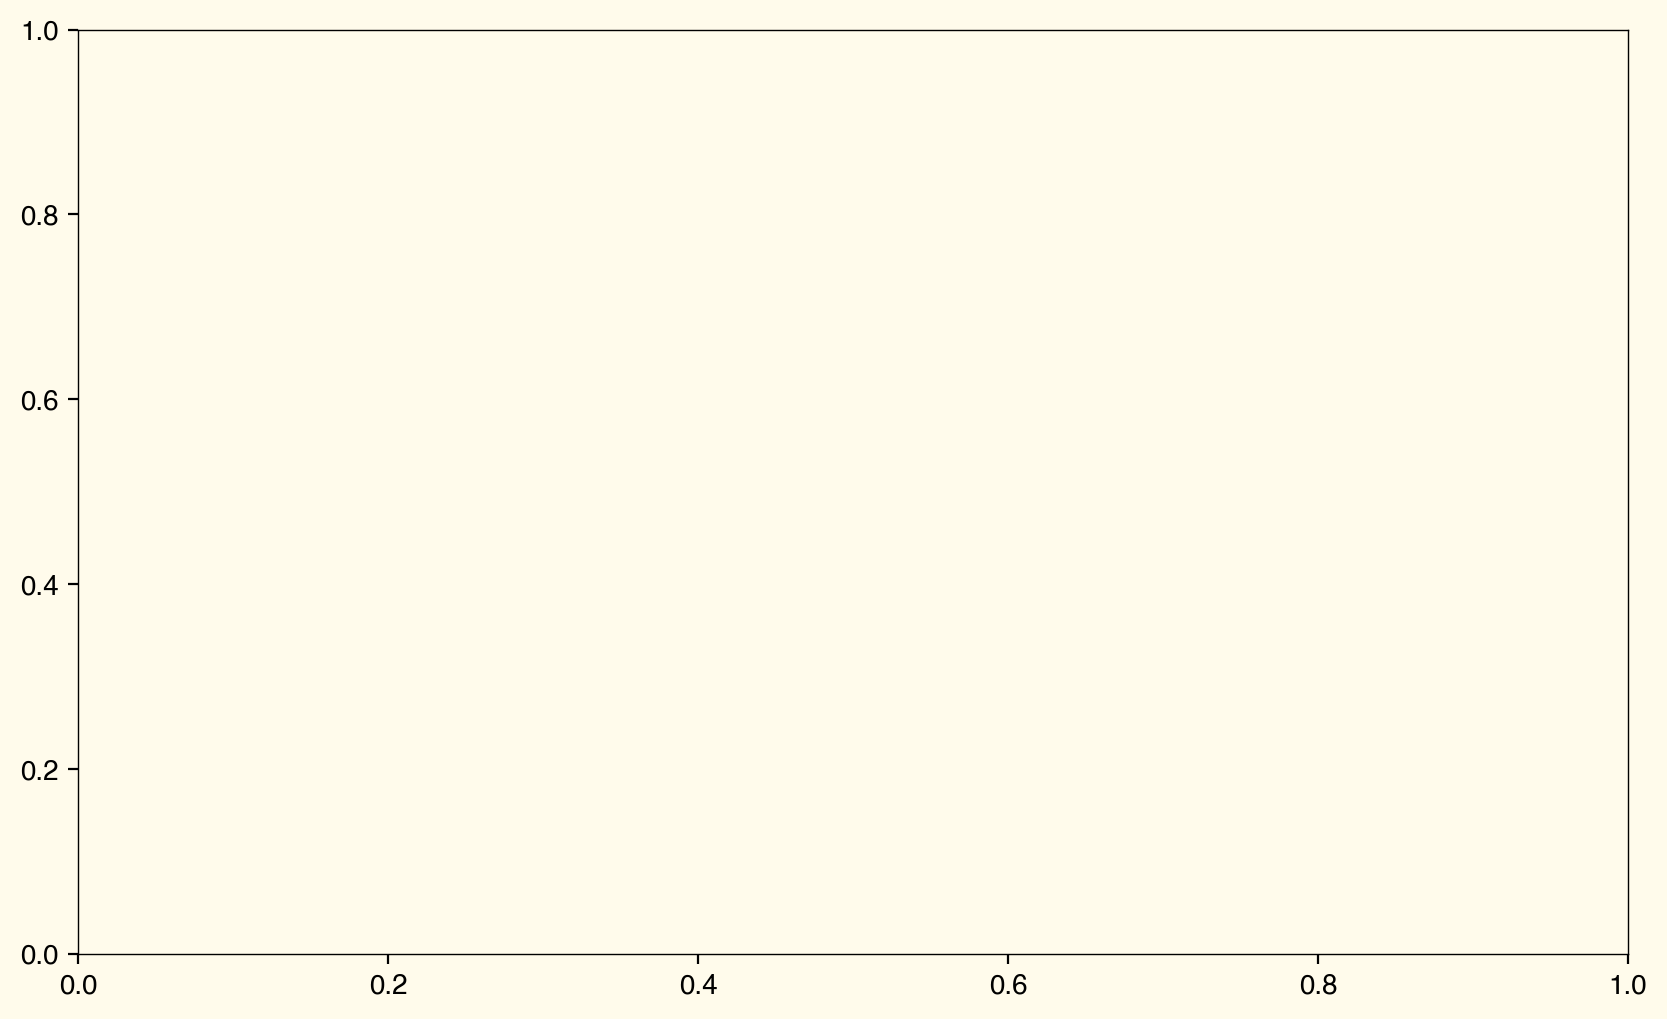

In [83]:
genreProps = list(topTenGenresDf['proportions'])

genreData = {}

for key in allGenres:
    ps = [d[key] for d in genreProps]
    genreData[key] = ps

plotDf = pd.DataFrame(genreData)
plotDf.index = topTenGenresDf.index

filtered = plotDf.index.get_level_values('year') > 1975
plotDf = plotDf[filtered]

# Create the stack plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the stack plot
ax.stackplot(plotDf.index, plotDf.T, labels=plotDf.columns)

# Adding labels and title
ax.set_title('Time Series Stack Plot of Genres')
ax.set_xlabel('Date')
ax.set_ylabel('Top Ten Proportion')
ax.legend(loc='upper left')

# Display the plot
plt.show()